In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut

/opt/miniconda3/envs/tf_tcg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
basin = 'NEP'
perc = 75
predictors_type = 'original+detrend' # 'original', 'deseason', 'detrend', 'original+detrend' (original predictions, detrended for timeseries comparison)
# Set parameters for run name
if predictors_type == 'original' or predictors_type == 'original+detrend':
    n_clusters_dict = {'NEP': 7, 'NWP': 10, 'NA': 6, 'NI': 7, 'SI': 6, 'SP': 9}
    str_pt = 'nc'
elif predictors_type == 'deseason':
    n_clusters_dict = {'NEP': 6, 'NWP': 10, 'NA': 10, 'NI': 8, 'SI': 8, 'SP': 9}
    str_pt = 'DSnc'
elif predictors_type == 'detrend':
    n_clusters_dict = {'NEP': 12, 'NWP': 10, 'NA': 12, 'NI': 11, 'SI': 7, 'SP': 10}
    str_pt = 'DTnc'
n_clusters = n_clusters_dict[basin]
run_name = f'selfeat{perc}_top20_{str_pt}{n_clusters}_nv8_nd9'

In [3]:
# Set years range and number of folds
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
# Set directories and file paths, then load file containing predictors and target
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
# Retrieve the clusters type of data from the results folder and the target file name
nc_string = run_name.split('_')[2]
if "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    target_file = 'target_deseasonal_1980-2022_2.5x2.5.csv'
elif "DT" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_detrend'
    target_file = 'target_detrend_1980-2022_2.5x2.5.csv'
elif predictors_type == 'original+detrend':
    cluster_data = f'{basin}_{n_clusters}clusters_detrend'
    target_file = 'target_detrend_1980-2022_2.5x2.5.csv'
else:
    cluster_data = f'{basin}_{n_clusters}clusters'
    target_file = 'target_1980-2022_2.5x2.5.csv'
fs_dir = os.path.join(project_dir, 'FS_TCG')
cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
# predictors
predictor_file = f'predictors_1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
predictors_df = pd.read_csv(os.path.join(cluster_data_dir, predictor_file), index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
predictors_df = predictors_df.loc[predictors_df.index.year.isin(years)]
# target
target_df = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
target_df.index = pd.to_datetime(target_df.index)
target_df = target_df.loc[target_df.index.year.isin(years)]
# gpis
gpis_file = f'{basin}_2.5x2.5_gpis_time_series.csv'
gpis_path = os.path.join(fs_dir, 'data', gpis_file)
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[gpis_df.index.year.isin(years)]
# Get the run info and data
Y_pred, Y_pred_noFS, X_test_eval, X_test_eval_noFS, mlps, mlps_noFS, shap_values_mlp = ut.runs_info(basin, run_name, project_dir)
# Convert list of dataframes to a single dataframe
X_test = pd.concat(X_test_eval)
X_test_noFS = pd.concat(X_test_eval_noFS)
Y_pred_df = pd.concat(Y_pred)
Y_pred_noFS_df = pd.concat(Y_pred_noFS)
# If predictions with original data are negative, set them to 0
if predictors_type == 'original' or predictors_type == 'original+detrend':
    Y_pred_df[Y_pred_df < 0] = 0.0
    Y_pred_noFS_df[Y_pred_noFS_df < 0] = 0.0
# Remove trend from predictions if considering the 'original+detrend' option
if predictors_type == 'original+detrend':
    decomp_pred_FS = STL(Y_pred_df['tcg']).fit()
    decomp_pred_noFS = STL(Y_pred_noFS_df['tcg']).fit()
    Y_pred_df['tcg'] = Y_pred_df['tcg'] - decomp_pred_FS.trend
    Y_pred_noFS_df['tcg'] = Y_pred_noFS_df['tcg'] - decomp_pred_noFS.trend

**Time series Trajectories** 

In [4]:
# Annual data without trend and seasonality
target_df_annual = target_df.groupby(target_df.index.year).sum()
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
# GPIs time series with trend and seasonality
engpi_TS = gpis_df['engpi']
ogpi_TS = gpis_df['ogpi']
# GPIs time series without trend and seasonality
decomp_engpi = STL(engpi_TS).fit()
decomp_ogpi = STL(ogpi_TS).fit()
if "DS" in nc_string:
    engpi = engpi_TS - decomp_engpi.seasonal
    ogpi = ogpi_TS - decomp_ogpi.seasonal
elif "DT" in nc_string or predictors_type == 'original+detrend':
    engpi = engpi_TS - decomp_engpi.trend
    ogpi = ogpi_TS - decomp_ogpi.trend
else:
    engpi = engpi_TS
    ogpi = ogpi_TS
# Annual data of the GPIs
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly without trend and seasonality
r, p_value = pearsonr(target_df['tcg'], Y_pred_df['tcg'])
r_noFS, p_value_noFS = pearsonr(target_df['tcg'], Y_pred_noFS_df['tcg'])
r_engpi, p_value_engpi = pearsonr(target_df['tcg'], engpi)
r_ogpi, p_value_ogpi = pearsonr(target_df['tcg'], ogpi)
mse = mean_squared_error(target_df['tcg'], Y_pred_df['tcg'])
mse_noFS = mean_squared_error(target_df['tcg'], Y_pred_noFS_df['tcg'])
mse_engpi = mean_squared_error(target_df['tcg'], engpi)
mse_ogpi = mean_squared_error(target_df['tcg'], ogpi)
# Annual without trend and seasonality
rY, p_valueY = pearsonr(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
rY_noFS, p_value_noFSY = pearsonr(target_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
rY_engpi, p_value_engpiY = pearsonr(target_df_annual['tcg'], engpi_annual)
rY_ogpi, p_value_ogpiY = pearsonr(target_df_annual['tcg'], ogpi_annual)
mseY = mean_squared_error(target_df_annual['tcg'], Y_pred_df_annual['tcg'])
mseY_noFS = mean_squared_error(target_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'])
mseY_engpi = mean_squared_error(target_df_annual['tcg'], engpi_annual)
mseY_ogpi = mean_squared_error(target_df_annual['tcg'], ogpi_annual)


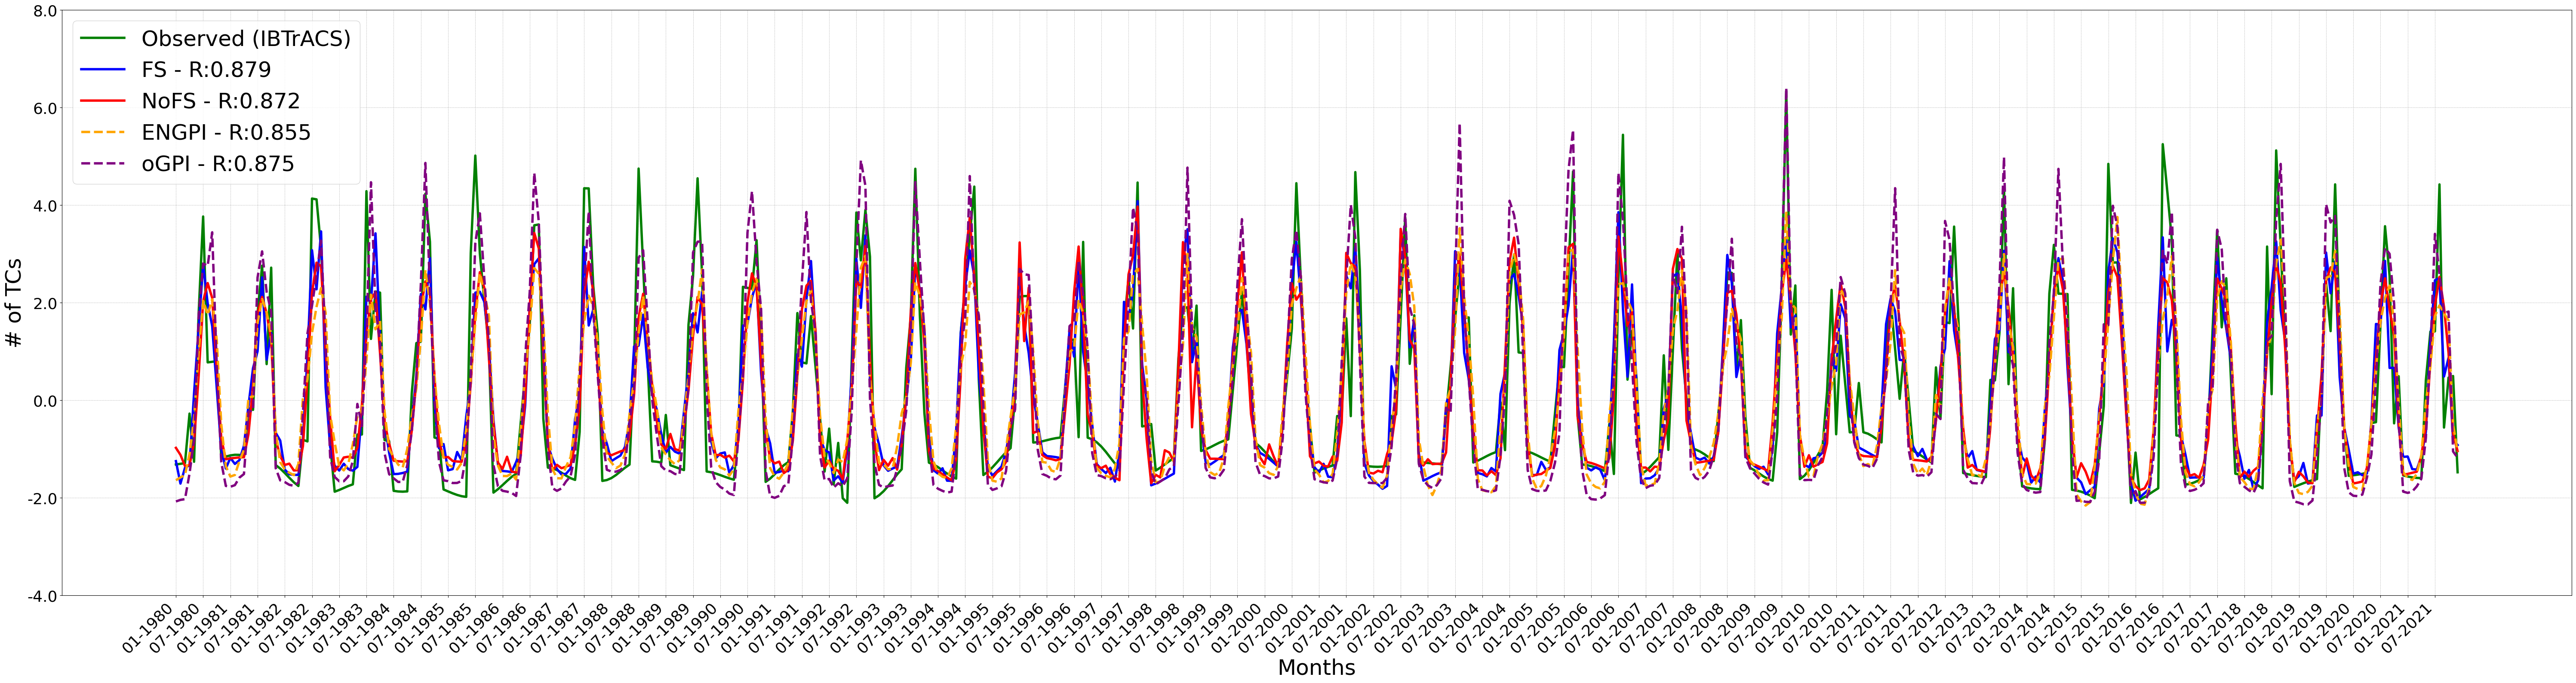

In [5]:
# Plotting the monthly time series 
fig_ts = ut.plot_monthly_time_series(target_df['tcg'], Y_pred_df['tcg'], Y_pred_noFS_df['tcg'], engpi, ogpi, r, r_noFS, r_engpi, r_ogpi)

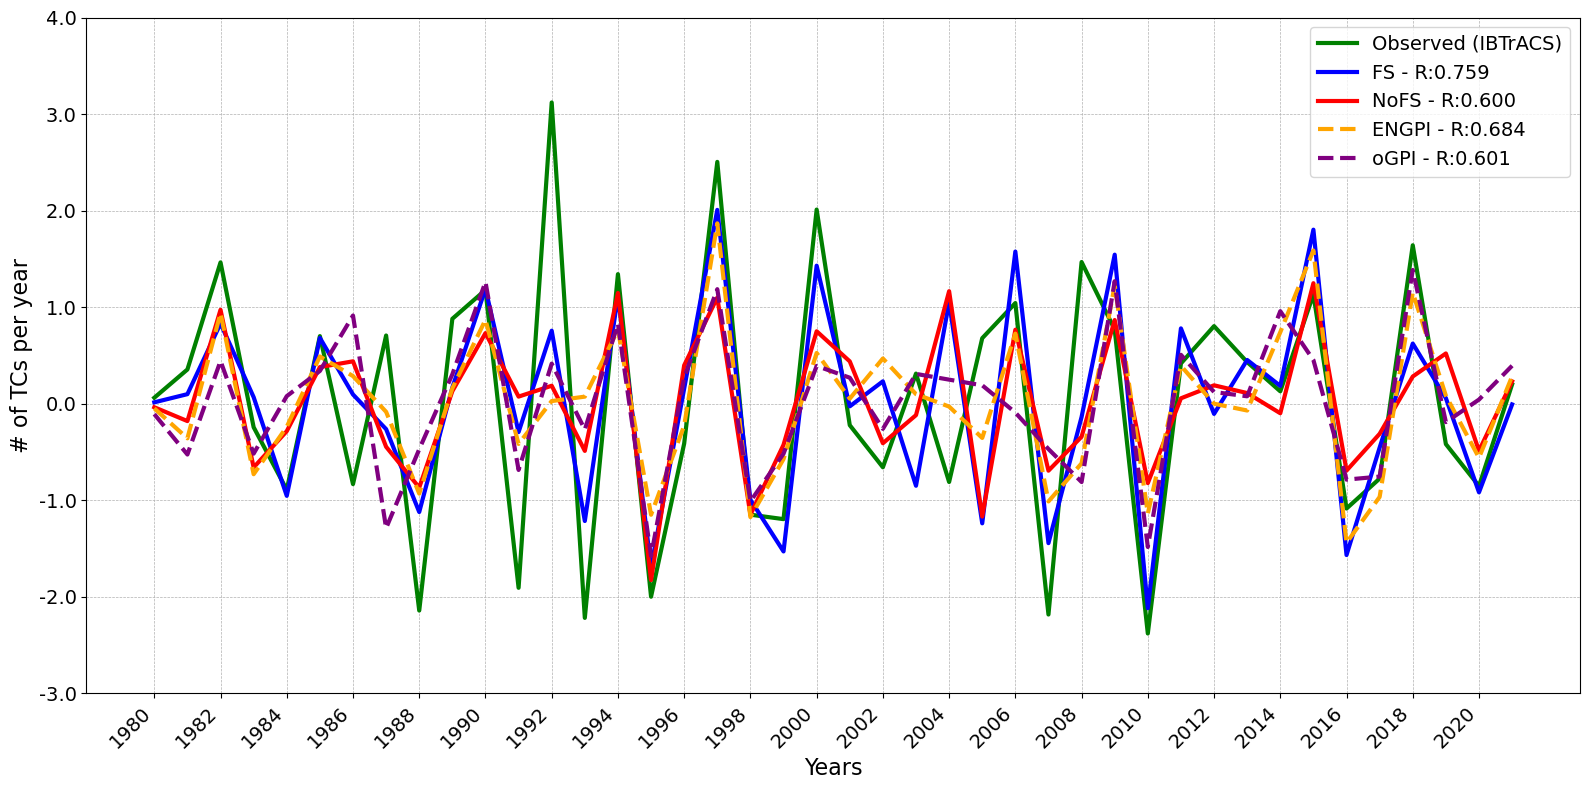

In [6]:
# Plotting the annual time series
fig_annual = ut.plot_annual_time_series(target_df_annual['tcg'], Y_pred_df_annual['tcg'], Y_pred_noFS_df_annual['tcg'], engpi_annual, ogpi_annual, rY, rY_noFS, rY_engpi, rY_ogpi)

In [7]:
print(f'=== annual mse ===')
print(f'fs: {mseY:.3f}')
print(f'noFS: {mseY_noFS:.3f}')
print(f'engpi: {mseY_engpi:.3f}')
print(f'ogpi: {mseY_ogpi:.3f}')
print(f'=== p values ===')
print(f'fs: {p_valueY:.3f}')
print(f'noFS: {p_value_noFSY:.3f}')
print(f'engpi: {p_value_engpiY:.3f}')
print(f'ogpi: {p_value_ogpiY:.3f}')

=== annual mse ===
fs: 0.733
noFS: 1.115
engpi: 0.939
ogpi: 1.108
=== p values ===
fs: 0.000
noFS: 0.000
engpi: 0.000
ogpi: 0.000


**Selected Features**

In [8]:
# Determine selected features according to the run_name
if 'selfeat' in run_name:
    perc = run_name.split('_top20')[0].split('selfeat')[1]
    csv_path = os.path.join(fs_dir, 'results', f'selected_features_best_models_{basin}_{nc_string}.csv')
    df_perc_sel = pd.read_csv(csv_path, index_col=0)
    selected_features = df_perc_sel[str(perc)].dropna().to_list()
elif 'test' in run_name:
    experiment_filename = f'1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
    sol_filename = 'linreg_' + experiment_filename
    output_dir = os.path.join(fs_dir, 'results', basin, run_name)
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    column_names = predictors_df.columns.tolist()
    final_sequence = best_solution[len(column_names):2*len(column_names)]
    sequence_length = best_solution[:len(column_names)]
    feat_sel = best_solution[2*len(column_names):]
    variable_selection = feat_sel.astype(int)
    time_sequences = sequence_length.astype(int)
    time_lags = final_sequence.astype(int)
    selected_features = []
    for c, col in enumerate(predictors_df.columns):
        if variable_selection[c] == 0 or time_sequences[c] == 0:
            continue
        for j in range(time_sequences[c]):
            selected_features.append(str(col))
else:
    raise ValueError(f'Unknown run name: {run_name}')
# Get the variables names and the selected clusters
variables_with_cluster = [var for var in selected_features if 'cluster' in var]
variables_without_cluster = [var for var in selected_features if 'cluster' not in var]
variable_names_cluster = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names_cluster = list(set(variable_names_cluster))
variable_names_cluster.sort()

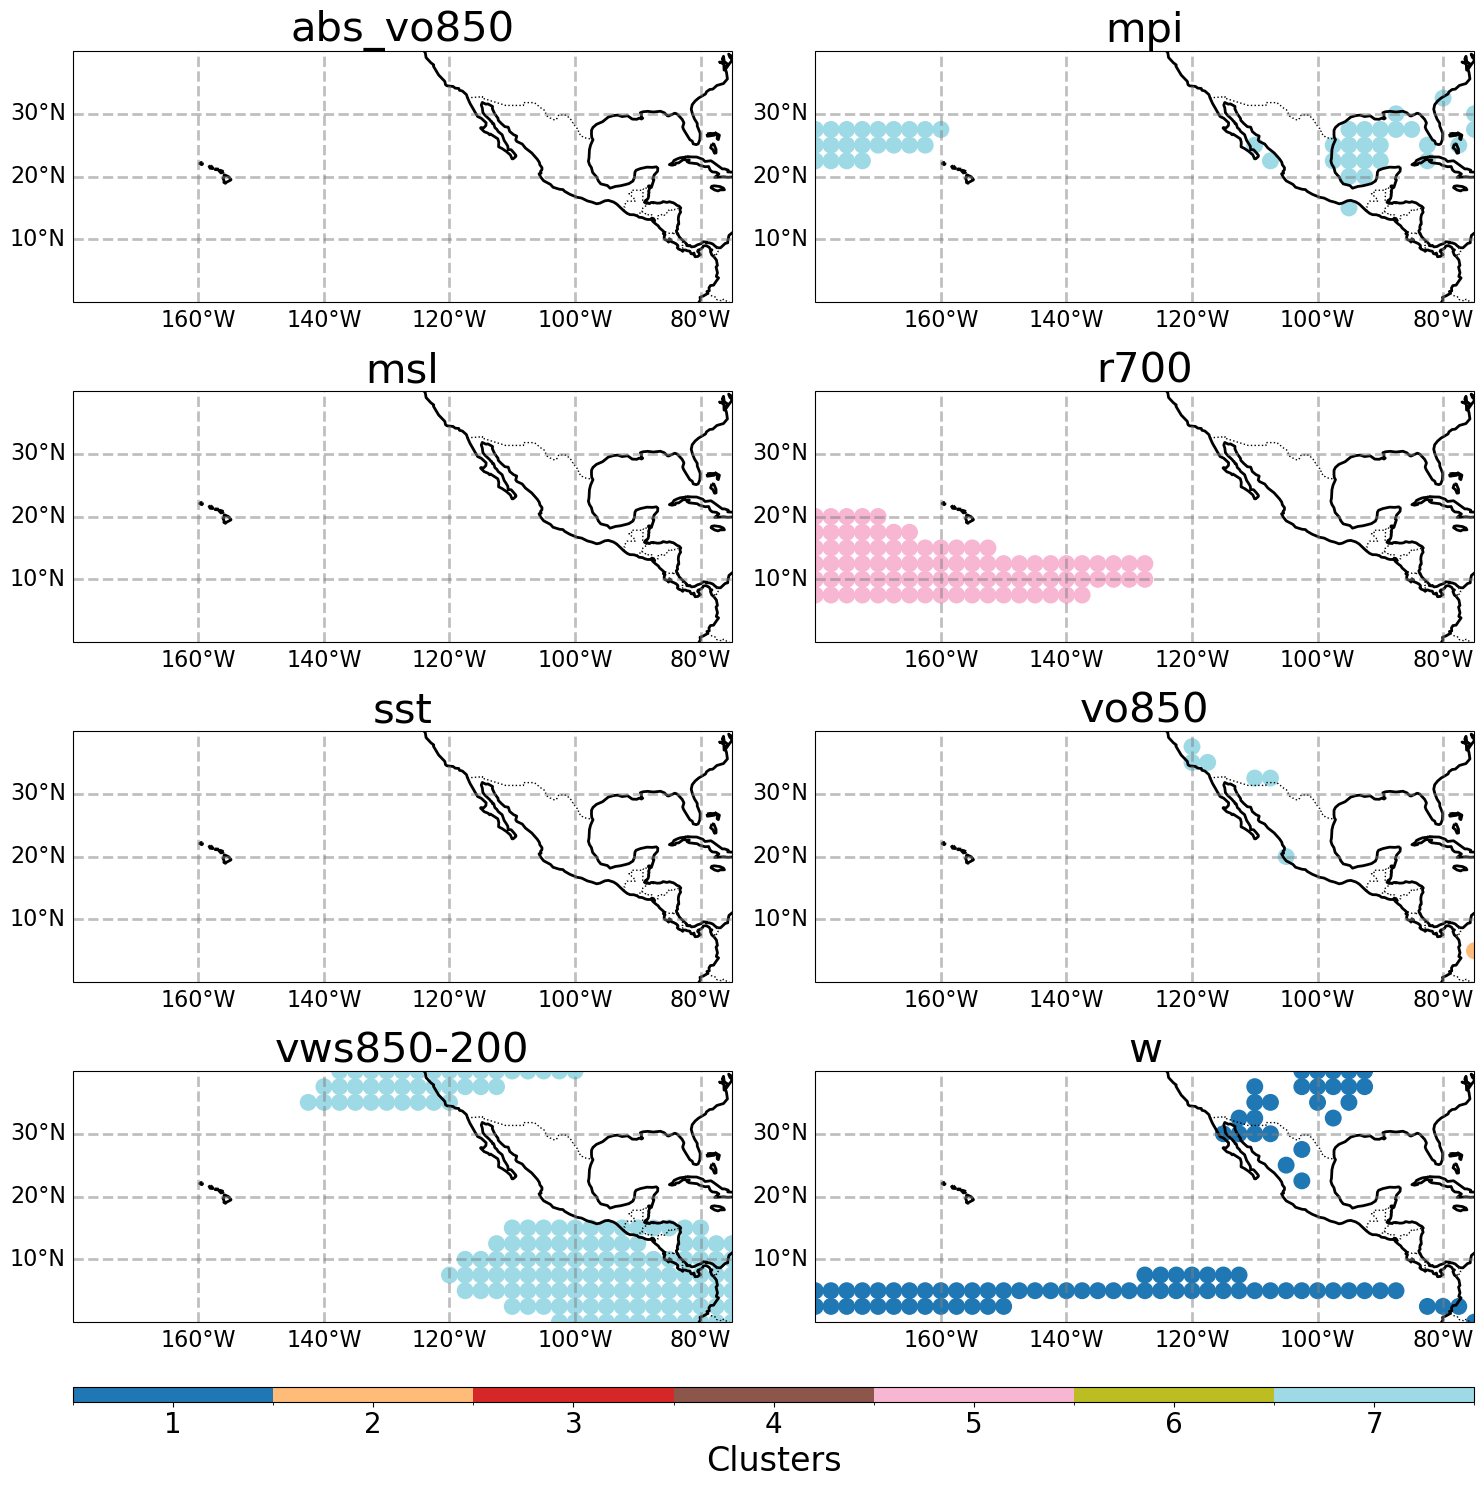

In [9]:
fig_clusters = ut.plot_variables_clusters(basin, n_clusters, cluster_data_dir, variable_names_cluster, selected_features)

**Print lines for LaTEX table**

In [10]:
# print(f'& FS-NN & {mse:.3f} & {r:.3f} & {mseS:.3f} & {rS:.4f} & {mseY:.3f} & {rY:.3f} \\\\')
# print(f'~ & NN & {mse_noFS:.3f} & {r_noFS:.3f} & {mseS_noFS:.3f} & {rS_noFS:.4f} & {mseY_noFS:.3f} & {rY_noFS:.3f} \\\\')
# print(f'~ & ENGPI & {mse_engpi:.3f} & {r_engpi:.3f} & {mseS_engpi:.3f} & {rS_engpi:.4f} & {mseY_engpi:.3f} & {rY_engpi:.3f} \\\\')
# print(f'~ & oGPI & {mse_ogpi:.3f} & {r_ogpi:.3f} & {mseS_ogpi:.3f} & {rS_ogpi:.4f} & {mseY_ogpi:.3f} & {rY_ogpi:.3f} \\\\')

**SHAP values**

In [11]:
## Set different parameters for following plots ##
years_couples = []
# Create a DataFrame with fold number corresponding to each year and also the couple of max and min years for each fold
kfold = KFold(n_splits=n_folds)
test_years_df = pd.DataFrame(0, index=years, columns=['fold'])
for nf, (train_index, test_index) in enumerate(kfold.split(years)):
    test_years_df.loc[years[test_index], 'fold'] = nf
    Y_pred_df_annual_fold = Y_pred_df_annual.loc[years[test_index]]
    max_fold = Y_pred_df_annual_fold['tcg'].idxmax()
    min_fold = Y_pred_df_annual_fold['tcg'].idxmin()
    years_couples.append((max_fold, min_fold))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


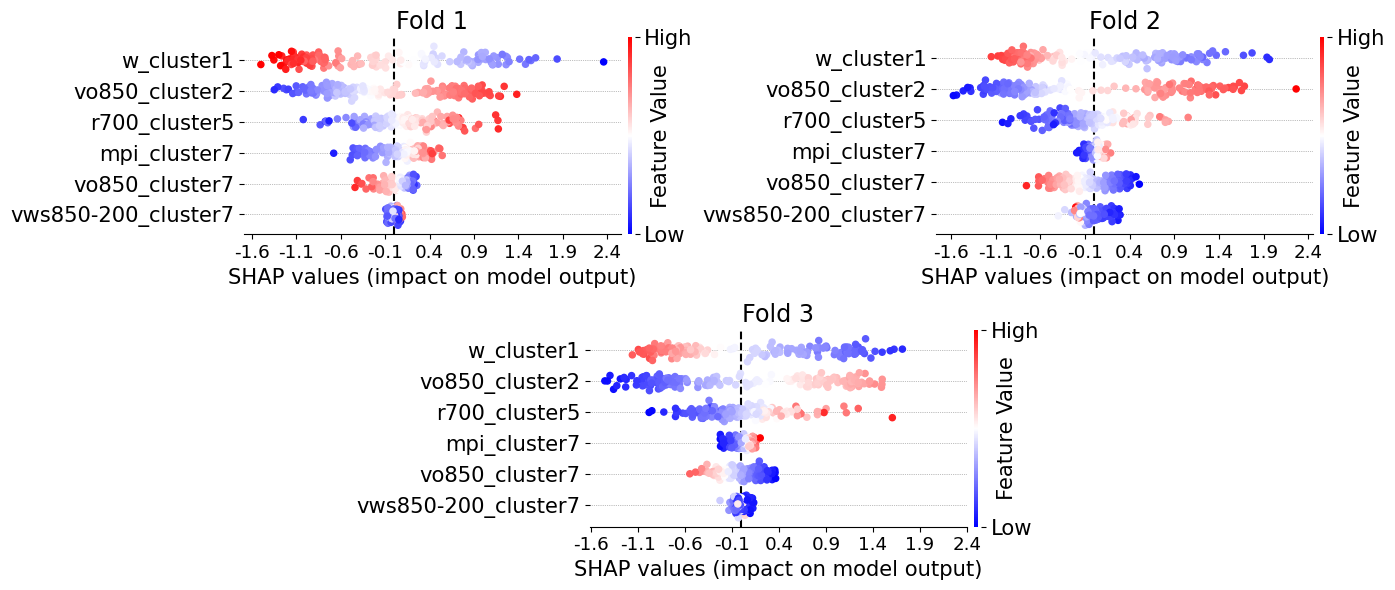

In [12]:
fig_shap = ut.plot_shap_values(shap_values_mlp)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


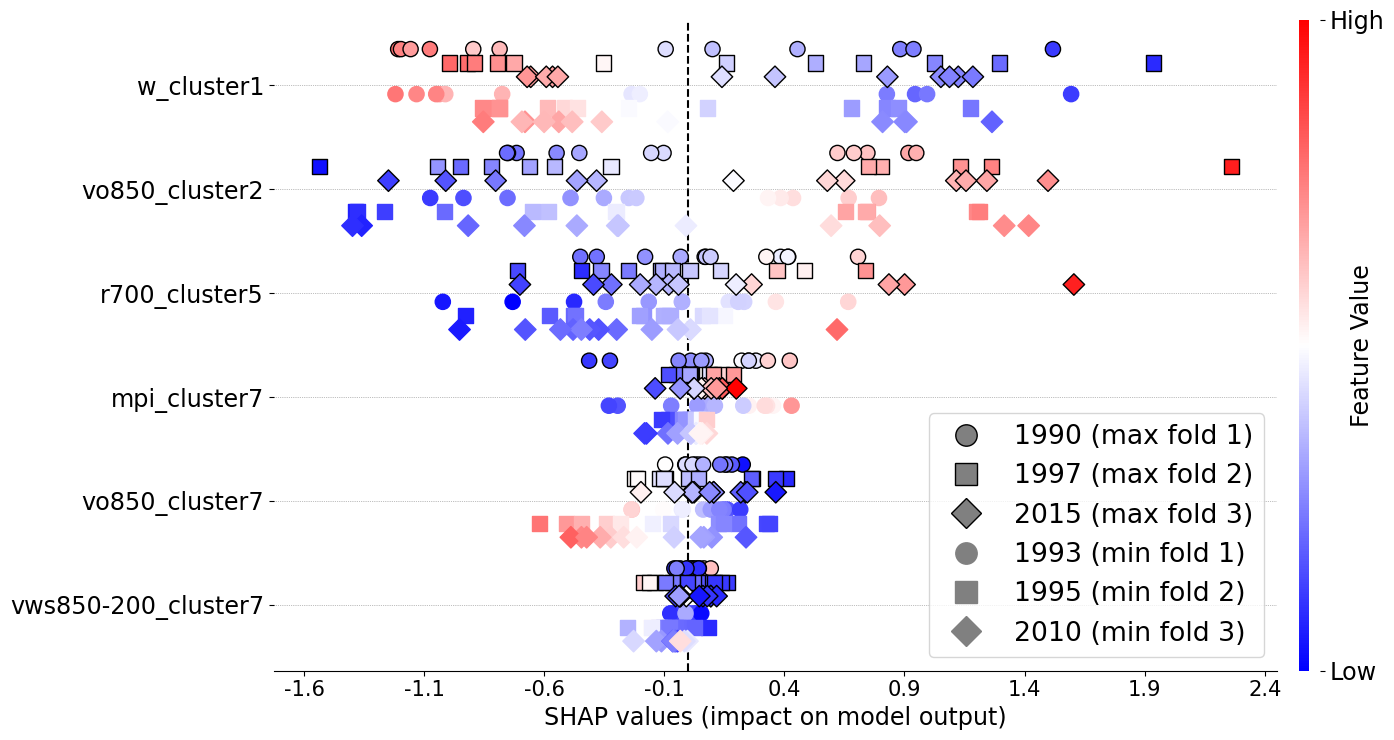

In [13]:
fig_shap_minmax = ut.plot_minmax_shap_values(shap_values_mlp, years_couples, Y_pred, test_years_df)